# Demonstrate Positional Bias

Our goal here is to quantify positional bias inherrent in our LLM.

# Setup

In [1]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from functools import partial
import json
import logging
import os
from pathlib import Path
from time import perf_counter_ns as timer
from uuid import uuid4

from pandas import DataFrame, Series
import rich
from rich.table import Table
from tqdm import tqdm

import llm_mcq_bias as lmb
from llm_mcq_bias.datasets.mmlu import Evaluation, OPTIONS
from llm_mcq_bias.models import Generator

In [2]:
def print_table(rows, title: str | None = None):
    table = Table(*[k for k in rows[0]], title=title, box=rich.box.SIMPLE)
    for row in rows:
        table.add_row(*[str(v) for v in row.values()])
    rich.print(table)

In [3]:
# Switch to project root
os.chdir("..")

logger = logging.getLogger(__name__)

# Parameters

In [4]:
# Provider config
providers = {
    "ollama": {
        "model": "llama3.2:3b",
        "options": {
            "num_predict": 10,  # Limit output tokens to avoid waiting for invalid responses
            "top_k": 1,  # Disable token sampling
        },
        "generator_factory": lmb.models.ollama,
    },
    "openai": {
        "model": "gpt-4o-mini",
        "options": {
            "max_tokens": 10,  # Limit output tokens to avoid waiting for invalid responses
            "temperature": 0,  # Disable token sampling
        },
        "generator_factory": lmb.models.openai,
    },
}

# Selected provider
provider = "ollama"

In [5]:
# Number of iterations
n_epochs = 1

# Number of questions to sample
n_questions = 16

# Number of parallel requests
n_jobs = 3

# Demonstrate Bias

In [6]:
dataset_path = Path(".build") / "datasets" / "mmlu"

# Load example questions
examples = lmb.datasets.mmlu.load_dataset(dataset_path, segment="dev")

# Debias example answer distribution
examples = lmb.datasets.mmlu.debias_example_answers(examples)

# Load test questions
questions = lmb.datasets.mmlu.load_dataset(dataset_path, segment="test")

# Initialize thread pool
executor = ThreadPoolExecutor(max_workers=n_jobs)

# Create generator from provider
generator_factory = providers[provider]["generator_factory"]
model = providers[provider]["model"]
options = providers[provider]["options"]
generator = partial(generator_factory, model=model, options=options)

print(f"Configured {provider} provider: {model}, {options}")

Configured ollama provider: llama3.2:3b, {'num_predict': 10, 'top_k': 1}


In [7]:
def answer_question(
    *,
    examples: DataFrame, 
    mcq: Series, 
    generator: Generator,
):
    """Answer a question."""
    
    # Generate prompt
    prompt = lmb.datasets.mmlu.generate_prompt(examples, mcq)

    # Generate answer
    answer = generator(prompt=prompt)

    # Evaluate answer
    return lmb.datasets.mmlu.evaluate_answer(mcq, answer)


def benchmark(
    description: str,
    *,
    examples: DataFrame,
    questions: DataFrame,
    generator: Generator,
):
    """Run experiment."""
    
    n = len(questions)

    start_time = timer()

    # Answer and evaluate each question in parallel
    futures = [
        executor.submit(
            answer_question, 
            examples=examples, 
            mcq=mcq, 
            generator=generator,
        ) for _, mcq in questions.iterrows()
    ]

    # Collect results
    correct, errors = 0, 0
    for future in tqdm(as_completed(futures), total=n, desc=description):
        evaluation = future.result()
        if evaluation is Evaluation.CORRECT:
            correct += 1
        elif evaluation is Evaluation.ERROR:
            errors += 1

    duration = timer() - start_time

    # Derive metrics
    metrics = {
        "n": n,
        "correct": correct,
        "errors": errors,
        "accuracy": correct / (n - errors),
        "error_rate": errors / n,
        "rps": 1000000000 * n / duration,
    }

    return metrics

### Verify Stable Benchmark Results

Let's make sure our benchmark process produces consistent results when run against the same inputs.

<Axes: xlabel='answer'>

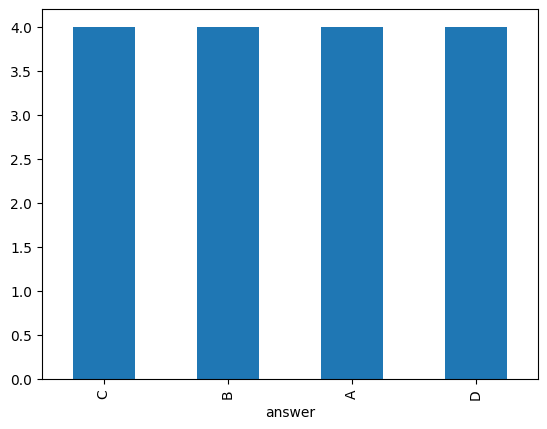

In [8]:
# Sample questions
selected_questions = questions.sample(n=16)

# Debias answer distribution
selected_questions = lmb.datasets.mmlu.debias_question_answers(selected_questions)

# Plot answer distribution
selected_questions.answer.value_counts().plot.bar()

In [9]:
# Print example prompt
print(lmb.datasets.mmlu.generate_prompt(examples, selected_questions.iloc[0]))

You are a robot that only outputs JSON. You reply in JSON format with the field 'answer'. For example, the following are multiple choice questions about formal logic.

Example Question:  Select the best English interpretation of the given arguments in predicate logic.
Dm
(∀x)(Wx ⊃ ~Dx)
(∀x)Wx ∨ Ag	/ (∃x)Ax

A) Marina is a dancer. No weakling is a dancer. Either everything is a weakling or Georgia plays volleyball. So something plays volleyball.
B) Marina is a dancer. No weakling is a dancer. Everything is either a weakling or plays volleyball. So something plays volleyball.
C) Marina is a dancer. Some weaklings are not dancers. Everything is either a weakling or plays volleyball. So something plays volleyball.
D) Marina is a dancer. Some weaklings are not dancers. Either everything is a weakling or Georgia plays volleyball. So something plays volleyball.

Example Answer: {"answer": "A"}

Example Question:  Construct a complete truth table for the following pairs of propositions. Then, 

In [10]:
%%time

rows = []
for i in range(3):
    # Run benchmark
    metrics = benchmark(
        f"epoch {i}",
        examples=examples,
        questions=selected_questions,
        generator=generator
    )

    rows.append(metrics)

print_table(rows)

epoch 2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.39it/s]


 n    correct   errors   accuracy   error_rate   rps                 
 ──────────────────────────────────────────────────────────────────── 
  16   8         0        0.5        0.0          1.4564757760458655  
  16   8         0        0.5        0.0          1.4299601017671324  
  16   8         0        0.5        0.0          1.3902359565708458

CPU times: user 104 ms, sys: 30 ms, total: 134 ms
Wall time: 33.7 s


## Estimate Positional Bias

In [14]:
%%time

# Repeat over multiple iterations
rows = []
for _ in range(n_epochs):
    # Sample questions
    selected_questions = questions.sample(n=n_questions)

    # Debias answer distribution
    selected_questions = lmb.datasets.mmlu.debias_question_answers(selected_questions)

    # Initialize metrics
    metrics = {}

    # Record performance w/ original data
    metrics["U"] = benchmark(
        "U",
        examples=examples,
        questions=selected_questions,
        generator=generator
    )

    # Record performance w/ answers shifted to each position
    for option in OPTIONS:
        # Swap answers to selected option
        q = lmb.datasets.mmlu.swap_options(selected_questions, option)

        metrics[option] = benchmark(
            option,
            examples=examples,
            questions=q,
            generator=generator
        )

    rows.append(metrics)

C: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.18it/s]

CPU times: user 158 ms, sys: 22.5 ms, total: 180 ms
Wall time: 1min 6s


In [12]:
table = Table("uniform", "A", "B", "C", "D", box=rich.box.SIMPLE)
for row in rows:
    baseline = row["uniform"]["accuracy"]
    offsets = {k: row[k]["accuracy"] - baseline for k in OPTIONS}
    colors = {option: "black" for option in OPTIONS}
    colors |= {option: "red" for option in OPTIONS if offsets[option] <= -0.05}
    colors |= {option: "green" for option in OPTIONS if offsets[option] >= 0.05}
    table.add_row(
        f"{baseline:0.2f}",
        f"[{colors['A']}]{offsets['A']:0.2f}[/{colors['A']}]",
        f"[{colors['B']}]{offsets['B']:0.2f}[/{colors['B']}]",
        f"[{colors['C']}]{offsets['C']:0.2f}[/{colors['C']}]",
        f"[{colors['D']}]{offsets['D']:0.2f}[/{colors['D']}]",
    )

rich.print(table)

 uniform   A   B   C   D  
 ─────────────────────────

# Export Results

In [16]:
model_name = model.replace(":", "-")
path = Path(f"notebooks/results/order-dependency-{model_name}-{n_questions}-{n_epochs}-{uuid4().hex}.json")
path.write_text(json.dumps(rows))

544